# Constant K

In [591]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', **{'size': 15})
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
import scipy.stats
from scipy.optimize import fsolve, root, curve_fit
import csv
import pandas as pd
from IPython.display import Image
import progressbar
import os

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def inch2m(inch):
    return inch * 0.0254

def m2inch(m):
    return m/0.0254

def loadcsvfile(filename, path='data/', delimiter=';'):
    exceldata = pd.read_excel(path+filename)
    exceldata.to_csv(path+'csv/'+filename[:-5]+'.csv', sep=delimiter, index=None, header=True)
    csvdata = pd.read_csv(path+'csv/'+filename[:-5]+'.csv', delimiter=delimiter)
    csvdata = csvdata.iloc[1:]
    csvdata.index -= 1
    for key in csvdata:
        if key != 'experiment':
            csvdata[key] = csvdata[key].astype('float')
    return csvdata

# Loading Noordland data and setting $h_0$ to $a_m$

In [194]:
# Noordland proeven (M1204)
NL1204 = loadcsvfile('Noordland_M1204.xlsx')
NL1204['h0'] = NL1204.am
#Noordland referentieproeven met delta_rho = 2
sel = np.arange(47)
NL1204ref = NL1204.iloc[sel]

In [422]:
NL1204D3Q1 = NL1204ref[(NL1204ref.Q==1e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q2 = NL1204ref[(NL1204ref.Q==2e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q3 = NL1204ref[(NL1204ref.Q==3e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q4 = NL1204ref[(NL1204ref.Q==4e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q5 = NL1204ref[(NL1204ref.Q==5e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q6 = NL1204ref[(NL1204ref.Q==6e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q7 = NL1204ref[(NL1204ref.Q==7e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q8 = NL1204ref[(NL1204ref.Q==8e-3) & (NL1204ref.D==3.1e-2)]

NL1204D6Q1 = NL1204ref[(NL1204ref.Q==1e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q2 = NL1204ref[(NL1204ref.Q==2e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q3 = NL1204ref[(NL1204ref.Q==3e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q5 = NL1204ref[(NL1204ref.Q==5e-3) & (NL1204ref.D==6.1e-2)]

reference_data = [NL1204D3Q1,NL1204D3Q3,NL1204D3Q5,NL1204D3Q7,
                  NL1204D6Q1,NL1204D6Q3,NL1204D6Q5]
refcol = np.array(['r', 'g', 'b', 'c', 'm', 'y', 'k'])

In [303]:
g = 9.81 # [m s^-2] gravitatieversnelling
rho_1 = 1000 # [kg m^-3] dichtheid zoet water
rho_2 = 1022 # [kg m^-3] dichtheid zout water
Drho = rho_2 - rho_1 # [kg m^-3] dichtheidsverschil
eps = Drho/rho_2
gp = eps*g

In [866]:
def transform(Gy, G, hL, P):
    return Gy + 2*G*(hL-P)

def func(x, a):
    return a - b*x

def linFit(x, y):
    """
    Linear fit through data.
    Returns:
    a: intercept
    b: slope
    r_value**2: R-squared
    p_value: P-value
    std_err: standard error
    """
    b, a, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return a, b, r_value**2, p_value, std_err

def fixedbFit(func, x, y):
    """
    Linear fit through data with a fixed value for the slope (b).
    Returns:
    a: intercept 
    r_squared: = R-squared
    """
    a = curve_fit(func, x, y)[0][0]
    residuals = y - func(x, *[a])
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return a, r_squared

In [920]:
coeffa = pd.DataFrame({'P':np.zeros(len(reference_data)),
                       'hL':np.zeros(len(reference_data)),
                       'a':np.zeros(len(reference_data)),
                       'b':np.zeros(len(reference_data))})

K = 0.55
#create new directory for new K value:
Kdir = 'K='+str(K)
figpath = "figures/constant_K/using_am/{}/".format(Kdir)
try:
    os.mkdir(figpath)
    print("New directory created: '{}'".format(figpath))
except:
    print("Directory '{}' already exists".format(figpath))
    
b = 1/(2*K)

print("Creating linear fits through Noordland reference data")
i = 0 #counter
for dataset in reference_data:
    plt.clf()
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title=r"Noordland reference experiments {0}-{1}".format(dataset.iloc[0].experiment, dataset.iloc[-1].experiment))
    ax.axis([-2,1,0,1])
    ax.grid()
    #select which dataset, leaving out the datapoints where lam=0
    sel = np.where(dataset.lam!=0)[0]
    NL1204sel = dataset
    P = NL1204sel.iloc[0].D/2
    G = pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)
    y = NL1204sel.D/2 - NL1204sel.h0
    Gy = G*y
    c0c2 = 1 - NL1204sel.lam

    Gyfit = np.linspace(-4,3,1000)

    #fit keeping b fixed
    a, rsq = fixedbFit(func, Gy.iloc[sel], c0c2.iloc[sel])
    c0c2fit = a - b*Gyfit
    hL = 1/(2*np.mean(G)*b)

    #linear fit through datapoints
    al, bl, rsql, pl, stdl = linFit(Gy.iloc[sel], c0c2.iloc[sel])
    bl = abs(bl)
    c0c2fitl = al - bl*Gyfit

    ax.plot(Gy, c0c2, 'o', color=refcol[i], label="Observed value")
    ax.plot(Gyfit, c0c2fit, 'k', label="${0:.2f}-{1:.2f}Gy$\n($R^2={2:.3f}$)".format(a,b,rsq))
    ax.plot(Gyfit, c0c2fitl, '-.k', label="${0:.2f}-{1:.2f}Gy$\n($R^2={2:.3f}$)".format(al,bl,rsql))

    coeffa.P[i] = P
    coeffa.hL[i] = hL
    coeffa.a[i] = a
    coeffa.b[i] = b
    
    #"""
    if P<hL:
        Gyp = transform(Gy, G, hL, P)
        ap = curve_fit(func, Gyp.iloc[sel], c0c2.iloc[sel])[0][0]
        c0c2fitp = ap - b*Gyfit
        coeffa.a[i] = ap
        coeffa.b[i] = b

        ax.plot(Gyp, c0c2, 'X', color=refcol[i], label="Adjusted value")
        ax.plot(Gyfit, c0c2fitp, '--k', label="${0:.2f}-{1:.2f}Gy'$".format(ap,b))
    #"""

    ax.legend()
    ax.invert_xaxis()
    plt.savefig(figpath+"{0}-{1}.png".format(dataset.iloc[0].experiment, dataset.iloc[-1].experiment))
    plt.close()
    i += 1

Directory 'figures/constant_K/using_am/K=0.55/' already exists
Creating linear fits through Noordland reference data


<Figure size 432x288 with 0 Axes>

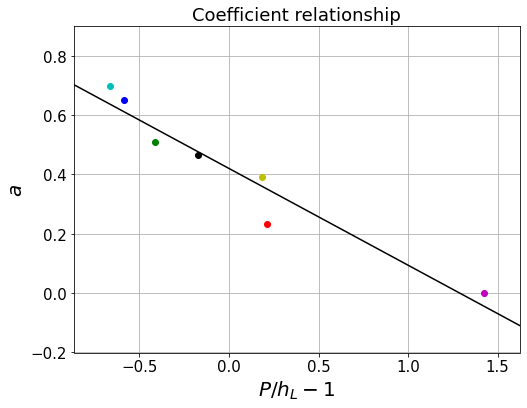

In [921]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set(xlabel=r"$P/h_L-1$", ylabel=r'$a$', title=r"Coefficient relationship".format(K))
ax.axis([min(coeffa.P/coeffa.hL-1)-0.2,max(coeffa.P/coeffa.hL-1)+0.2,
         min(coeffa.a)-0.2, max(coeffa.a)+0.2])
ax.grid()

xfit = np.linspace(-20,20,1000)
intercept, slope, r_squared, p_value, std_err = linFit(coeffa.P/coeffa.hL-1, coeffa.a)
afit = slope*xfit+intercept

[ax.plot(coeffa.P[i]/coeffa.hL[i]-1, coeffa.a[i], 'o', color=refcol[i]) for i in range(len(reference_data))]
ax.plot(xfit,afit,'k')

plt.savefig(figpath+"Coefficient relationship")

# Computed versus observed

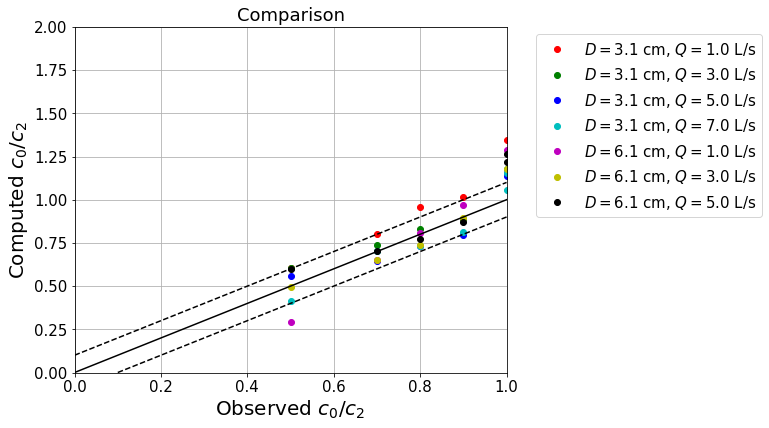

In [922]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.set(xlabel=r"Observed $c_0/c_2$", ylabel=r'Computed $c_0/c_2$', title=r"Comparison".format(K))
ax.axis([0,1,0,2])
ax.grid()
ax.set_position([0.1,0.1,0.5,0.8])

i = 0
for NL1204sel in reference_data:
    #NL1204sel = NL1204ref

    c0c2obs = 1 - NL1204sel.lam
    G = pow(NL1204sel.rhofrac*9.81/NL1204sel.q**2,1/3)
    P = NL1204sel.D/2
    y = P - NL1204sel.h0

    hL = K/G
    acomp = np.interp(P/hL-1,xfit,afit)
    c0c2comp = acomp - b*G*y
    # if P<hL, the value of a from the graph is for y', so transformation back to y is needed:
    c0c2comp[P<=hL] = acomp[P<=hL] - b*G[P<=hL]*(y[P<=hL] + 2*(hL[P<=hL]-P[P<=hL]))
    # forcing c0/c2 to 0 or 1 when the computed value is <0 or >1, respectively:
    #c0c2comp[NL1204sel.h0<=P-hL] = 0
    #c0c2comp[NL1204sel.h0>=P+hL] = 1
    
    ax.plot(c0c2obs, c0c2comp, 'o', color=refcol[i], label='$D={0}$ cm, $Q={1}$ L/s'.format(NL1204sel.iloc[0].D*100, NL1204sel.iloc[0].Q_1000))
    i+=1
    
ax.axline([1,1],slope=1, color='k')
ax.axline([1,1.1],slope=1, color='k', linestyle='--')
ax.axline([1.1,1],slope=1, color='k', linestyle='--')

plt.legend(loc='upper left', bbox_to_anchor=(1.05,1))

plt.savefig(figpath+"comparison_plot.png")

# All Noordland data

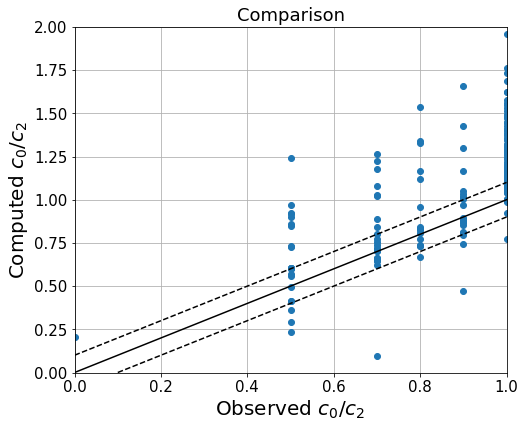

In [925]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.set(xlabel=r"Observed $c_0/c_2$", ylabel=r'Computed $c_0/c_2$', title=r"Comparison".format(K))
ax.axis([0,1,0,2])
ax.grid()
ax.set_position([0.1,0.1,0.5,0.8])

NL1204sel = NL1204

c0c2obs = 1 - NL1204sel.lam
G = pow(NL1204sel.rhofrac*9.81/NL1204sel.q**2,1/3)
P = NL1204sel.D/2
y = P - NL1204sel.h0

hL = K/G
acomp = np.interp(P/hL-1,xfit,afit)
c0c2comp = acomp - b*G*y
# if P<hL, the value of a from the graph is for y', so transformation back to y is needed:
c0c2comp[P<=hL] = acomp[P<=hL] - b*G[P<=hL]*(y[P<=hL] + 2*(hL[P<=hL]-P[P<=hL]))
# forcing c0/c2 to 0 or 1 when the computed value is <0 or >1, respectively:
#c0c2comp[NL1204sel.h0<=P-hL] = 0
#c0c2comp[NL1204sel.h0>=P+hL] = 1

ax.plot(c0c2obs, c0c2comp, 'o')

ax.axline([1,1],slope=1, color='k')
ax.axline([1,1.1],slope=1, color='k', linestyle='--')
ax.axline([1.1,1],slope=1, color='k', linestyle='--')

plt.show()

# Looping over different values of K to choose best

In [871]:
K_arr = np.linspace(0.1,2,500)

fitstats = pd.DataFrame({
    'K': K_arr,
    'rsq': np.zeros(len(K_arr)),
    'p_value': np.zeros(len(K_arr)),
    'std_err': np.zeros(len(K_arr))
})

coeffa = pd.DataFrame({
    'P':np.zeros(len(reference_data)),
    'hL':np.zeros(len(reference_data)),
    'a':np.zeros(len(reference_data)),
    'b':np.zeros(len(reference_data))
})

for jj in range(len(K_arr)):
    K = K_arr[jj]  
    b = 1/(2*K)

    i = 0 #counter
    for dataset in reference_data:
        #select which dataset, leaving out the datapoints where lam=0
        sel = np.where(dataset.lam!=0)[0]
        NL1204sel = dataset
        P = NL1204sel.iloc[0].D/2
        G = pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)
        y = NL1204sel.D/2 - NL1204sel.h0
        Gy = G*y
        c0c2 = 1 - NL1204sel.lam

        Gyfit = np.linspace(-4,3,1000)

        #fit keeping b fixed
        a, rsq = fixedbFit(func, Gy.iloc[sel], c0c2.iloc[sel])
        c0c2fit = a - b*Gyfit
        hL = 1/(2*np.mean(G)*b)

        #linear fit through datapoints
        al, bl, rsql, pl, stdl = linFit(Gy.iloc[sel], c0c2.iloc[sel])
        bl = abs(bl)
        c0c2fitl = al - bl*Gyfit

        coeffa.P[i] = P
        coeffa.hL[i] = hL
        coeffa.a[i] = a
        coeffa.b[i] = b

        #"""
        if P<hL:
            Gyp = transform(Gy, G, hL, P)
            ap = curve_fit(func, Gyp.iloc[sel], c0c2.iloc[sel])[0][0]
            c0c2fitp = ap - b*Gyfit
            coeffa.a[i] = ap
            coeffa.b[i] = b
        #"""

        i += 1

    xfit = np.linspace(-20,20,1000)
    intercept, slope, r_squared, p_value, std_err = linFit(coeffa.P/coeffa.hL-1, coeffa.a)
    afit = slope*xfit+intercept
    fitstats.rsq[jj], fitstats.p_value[jj], fitstats.std_err[jj] = r_squared, p_value, std_err

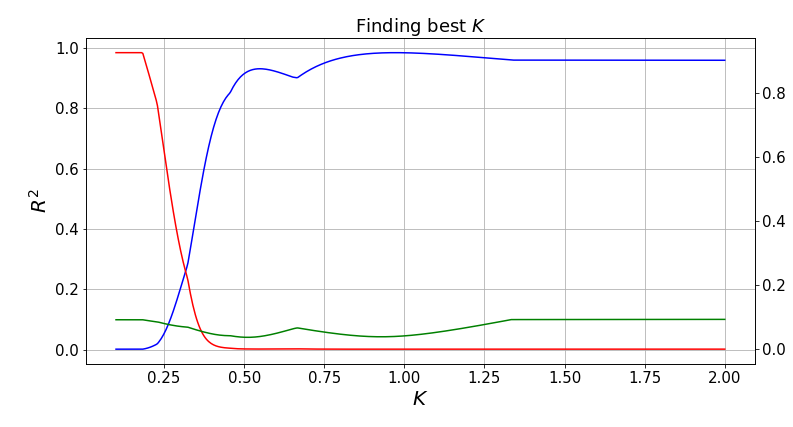

In [885]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.set(xlabel=r"$K$", ylabel=r'$R^2$', title=r"Finding best $K$")
#ax.axis([0,1,0,2])
ax.grid()
ax.set_position([0.1,0.1,0.5,0.8])
bx = ax.twinx()

ax.plot(fitstats.K, fitstats.rsq, 'b')
bx.plot(fitstats.K, fitstats.p_value, 'r')
bx.plot(fitstats.K, fitstats.std_err, 'g')

In [892]:
first = fitstats[fitstats.K<0.6]
second = fitstats[fitstats.K>=0.6]
print(first[first.rsq==max(first.rsq)])
print(second[second.rsq==max(second.rsq)])


            K       rsq   p_value   std_err
118  0.549299  0.931016  0.000435  0.039607
            K       rsq  p_value   std_err
229  0.971944  0.984333  0.00001  0.039785
